In [1]:
import numpy as np
from skimage import io
from skimage.filters import sobel_h, sobel_v
import matplotlib.pyplot as plt
from os import listdir
%matplotlib inline

In [56]:
import numpy as np
from skimage.filters import sobel_h, sobel_v
from skimage.transform import resize

def get_grad(image):
    def get_luminance(image):
        RC = 0.299
        GC = 0.587
        BC = 0.114
        f = image.astype(np.float64)
        return f[:,:,0] * RC + f[:,:,1] * GC + f[:,:,2] * BC
    luminance = get_luminance(image)
    s_x = -sobel_v(luminance)
    s_y = sobel_h(luminance)
    grad = np.sqrt(s_x ** 2 + s_y ** 2)
    angle = np.arctan2(s_y, s_x)
    return grad, angle

def get_cells(grad, angle, orient=9, pixels_per_cell=(8, 8), step=(8, 8)):
    rows_per_cell = pixels_per_cell[0]
    columns_per_cell = pixels_per_cell[1]
    shape = grad.shape
    cells = np.zeros((int(np.ceil(shape[0] / step[0])), int(np.ceil(shape[1] / step[1])), orient))
    for i in range(0, shape[0], step[0]):
        for j in range(0, shape[1], step[1]):
            i_2 = i + rows_per_cell
            j_2 = j + columns_per_cell
            hist, _ = np.histogram(angle[i:i_2, j:j_2], bins=orient, range=(-np.pi, np.pi), weights=grad[i:i_2, j:j_2])
            cells[i // step[0], j // step[1]] = hist
    return cells

def get_blocks(cells, cells_per_block=(2, 2), step=(1, 1), eps=0.00001):
    rows_per_block = cells_per_block[0]
    columns_per_block = cells_per_block[1]
    shape = cells.shape
    blocks = np.zeros((int(np.ceil(shape[0] / step[0])), int(np.ceil(shape[1] / step[1])), 
                       shape[2] * rows_per_block * columns_per_block))
    for i in range(0, shape[0], step[0]):
        for j in range(0, shape[1], step[1]):
            i_2 = i + rows_per_block
            j_2 = j + columns_per_block
            block = np.zeros(shape[2] * rows_per_block * columns_per_block)
            block[:np.ravel(cells[i:i_2, j:j_2, :]).shape[0]] = np.ravel(cells[i:i_2, j:j_2, :])
            blocks[i // step[0], j // step[1]] = block / np.sqrt(np.sum(block ** 2) + eps)
    return blocks

def extract_hog(image):
    image = resize(image, output_shape=(64, 64))
    grad, angle = get_grad(image)
    cells = get_cells(grad, angle, orient=8, pixels_per_cell=(8,8), step=(8,8))
    blocks = get_blocks(cells, cells_per_block=(2, 2), step=(1, 1))
    return blocks.flatten()

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


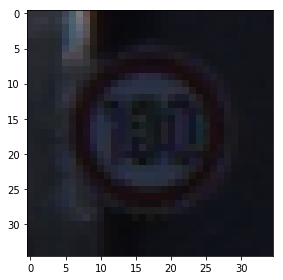

In [3]:
image = io.imread("public_data/00_input/train/11112.png")
io.imshow(image)

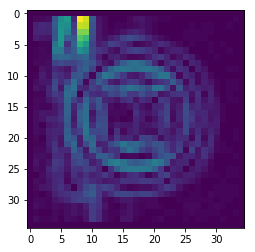

In [4]:
grad, angle = get_grad(image)
plt.imshow(grad.astype(int))

In [5]:
grad.shape, angle.shape

((35, 35), (35, 35))

In [5]:
hog = extract_hog(image)

hog.shape

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(512,)

In [9]:
from tqdm import tqdm_notebook

In [10]:
import pandas as pd

In [58]:
DIR = "public_data/00_input/train/"
shapes = []
pics_names = []
features = np.zeros((len(listdir(DIR)), 2048))
pic_to_ind = {}

for pic in tqdm_notebook(listdir(DIR)):
    if not pic.endswith('png'):
        continue
    image = io.imread(DIR + pic)
    ind = len(pics_names)
    features[ind] = extract_hog(image)
    pic_to_ind[pic] = ind
    pics_names.append(pic)
    
features = features[:len(pics_names), :]

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
features.shape

(39209, 512)

In [14]:
data = pd.read_csv('public_data/00_input/train/gt.csv')
data.head()

,filename,class_id
0,00000.png,0
1,00001.png,0
2,00002.png,0
3,00003.png,0
4,00004.png,0


In [59]:
labels = np.zeros(features.shape[0])
for row in tqdm_notebook(data.iterrows()):
    labels[pic_to_ind[row[1]['filename']]] = row[1]['class_id']

In [16]:
labels

array([12., 40.,  4., ..., 23., 38., 12.])

In [17]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27446, 2048), (27446,), (11763, 2048), (11763,))

In [18]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components=128)
new_feat = pca.fit_transform(features)

In [32]:
new_feat.shape

(39209, 128)

In [25]:
from sklearn.svm import SVC
model = SVC(kernel='linear', verbose=True)
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [38]:
from sklearn.svm import LinearSVC

In [31]:
model.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [32]:
%%time
pred = model.predict(X_test)

CPU times: user 6min 35s, sys: 2.45 s, total: 6min 38s
Wall time: 6min 48s


In [26]:
from sklearn.metrics import accuracy_score

In [33]:
pred

array([38., 10., 28., ...,  5.,  2., 38.])

In [34]:
accuracy_score(y_test, pred)

0.9913287426676868

In [23]:
from sklearn.model_selection import cross_val_score

In [61]:
%%time
cv_score = cross_val_score(LinearSVC(), features, labels, scoring='accuracy', cv=5, n_jobs=-1, verbose=4)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.9812547819433818, total= 1.9min
[CV]  ................................................................
[CV] ....................... , score=0.9831675592960979, total= 2.0min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min


[CV] ....................... , score=0.9795970415710278, total= 2.0min
[CV] ....................... , score=0.9812547819433818, total= 2.0min
[CV] ....................... , score=0.9774263486800153, total= 1.2min
CPU times: user 5.05 s, sys: 393 ms, total: 5.44 s
Wall time: 3min 9s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


In [27]:
cv_score

array([0.97130834, 0.97436878, 0.97640908, 0.97398623, 0.97041194])

In [60]:
%%time
cv_score = cross_val_score(LinearSVC(), features, labels, scoring='accuracy', cv=3, n_jobs=-1, verbose=5)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.9733741392501912, total= 1.3min
[CV] ....................... , score=0.9752850256331778, total= 1.3min
[CV] ....................... , score=0.9730680948737567, total= 1.4min
CPU times: user 3.06 s, sys: 396 ms, total: 3.46 s
Wall time: 1min 23s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


In [35]:
cv_score

array([0.9510329 , 0.94407039, 0.94865713])

In [52]:
%%time
!python run_tests.py public_data

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
00 639.78s Ok, accuracy 0.9999
Mark: 10 0.9999
CPU times: user 9.36 s, sys: 2.87 s, total: 12.2 s
Wall time: 10min 40s
